## Corn leaf disease image classification using fine tuning

### Import Library

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score
from sklearn.utils import resample
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization, Flatten, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.regularizers import l2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model, load_model, Sequential, save_model
from tensorflow.keras.metrics import categorical_crossentropy

### Preparing the Dataset

In [2]:
sdir=r"C:\Users\asus\Bayu\Kuliah\SMT 7\Bangkit\Capstone\capstone_env\Corn\Corn Leaf Old"

filepaths=[]
labels=[]
classlist=os.listdir(sdir)
for klass in classlist:
    classpath=os.path.join(sdir,klass)
    if os.path.isdir(classpath):
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)
Fseries= pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')
df=pd.concat([Fseries, Lseries], axis=1)
print(df)
print (df['labels'].value_counts())

                                              filepaths       labels
0     C:\Users\asus\Bayu\Kuliah\SMT 7\Bangkit\Capsto...  Common Rust
1     C:\Users\asus\Bayu\Kuliah\SMT 7\Bangkit\Capsto...  Common Rust
2     C:\Users\asus\Bayu\Kuliah\SMT 7\Bangkit\Capsto...  Common Rust
3     C:\Users\asus\Bayu\Kuliah\SMT 7\Bangkit\Capsto...  Common Rust
4     C:\Users\asus\Bayu\Kuliah\SMT 7\Bangkit\Capsto...  Common Rust
...                                                 ...          ...
3995  C:\Users\asus\Bayu\Kuliah\SMT 7\Bangkit\Capsto...  Leaf Blight
3996  C:\Users\asus\Bayu\Kuliah\SMT 7\Bangkit\Capsto...  Leaf Blight
3997  C:\Users\asus\Bayu\Kuliah\SMT 7\Bangkit\Capsto...  Leaf Blight
3998  C:\Users\asus\Bayu\Kuliah\SMT 7\Bangkit\Capsto...  Leaf Blight
3999  C:\Users\asus\Bayu\Kuliah\SMT 7\Bangkit\Capsto...  Leaf Blight

[4000 rows x 2 columns]
labels
Common Rust       1000
Grey Leaf Spot    1000
Healthy           1000
Leaf Blight       1000
Name: count, dtype: int64


### Spliting Data

In [3]:
train_split=.9
test_split=.05
dummy_split=test_split/(1-train_split)
train_df, dummy_df=train_test_split(df, train_size=train_split, shuffle=True, random_state=123)
test_df, valid_df=train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=123)
print ('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))

train_df length:  3600   test_df length:  200   valid_df length:  200


In [4]:
# Definisikan ukuran gambar dan batch size
height = 256
width = 256
channels = 3
batch_size = 64

img_shape = (height, width, channels)
img_size = (height, width)

# Hitung ukuran batch untuk data pengujian
length = len(test_df)
test_batch_size = sorted([int(length/n) for n in range(1, length+1) if length % n == 0 and length/n <= 80], reverse=True)[0]
test_steps = int(length/test_batch_size)
print('Test batch size:', test_batch_size, ' Test steps:', test_steps)

Test batch size: 50  Test steps: 4


### Data Preprocessing

In [5]:
# Normalisasi dan augmentasi data
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalisasi nilai piksel
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.3,
    zoom_range=0.3,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True
)
    

# Normalisasi data pengujian dan validasi
test_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
# Flow dari DataFrame
train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

Found 3600 validated image filenames belonging to 4 classes.


In [7]:
valid_gen = valid_datagen.flow_from_dataframe(
    valid_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

Found 200 validated image filenames belonging to 4 classes.


In [8]:
test_gen = test_datagen.flow_from_dataframe(
    test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=test_batch_size
)

Found 200 validated image filenames belonging to 4 classes.


In [9]:
# Daftar kelas
classes = list(train_gen.class_indices.keys())
print(classes)
class_count = len(classes)

['Common Rust', 'Grey Leaf Spot', 'Healthy', 'Leaf Blight']


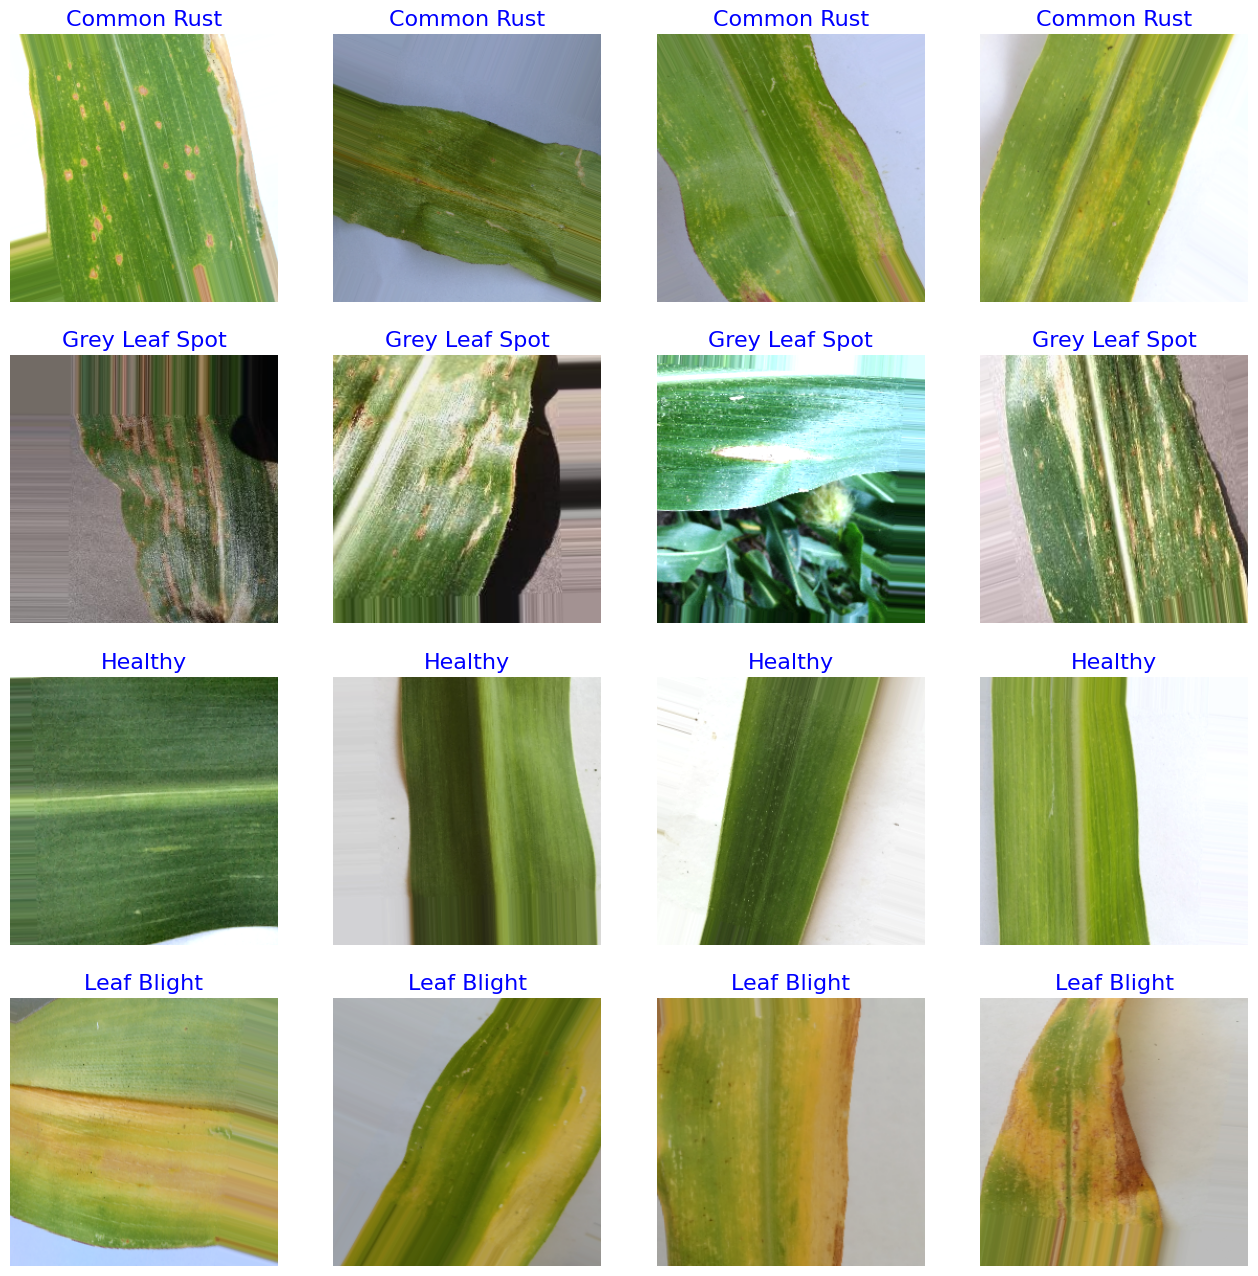

In [10]:
def show_ordered_image_samples(gen):
    # Mendapatkan daftar kelas dari generator
    test_dict = gen.class_indices
    classes = list(test_dict.keys())
    num_classes = len(classes)
    
    # Mengambil batch gambar dan label dari generator
    images, labels = next(gen)
    
    # Menyiapkan dictionary untuk mengelompokkan gambar berdasarkan kelas
    class_images = {class_name: [] for class_name in classes}
    
    # Mengelompokkan gambar berdasarkan kelas
    for i in range(len(labels)):
        index = np.argmax(labels[i])  # Mendapatkan indeks kelas dari label
        class_name = classes[index]
        class_images[class_name].append(images[i])  # Menambahkan gambar ke kelompok kelas

    # Memulai visualisasi
    plt.figure(figsize=(16, 16))
    image_count = 0

    # Menampilkan 4x4 gambar pertama sesuai urutan kelas
    for class_name in classes:
        for img in class_images[class_name][:4]:  # Mengambil 4 gambar pertama dari setiap kelas
            plt.subplot(4, 4, image_count + 1)
            plt.imshow(img)
            plt.title(class_name, color='blue', fontsize=16)
            plt.axis('off')
            image_count += 1
            
            # Berhenti setelah menampilkan 16 gambar (4x4 grid)
            if image_count >= 16:
                break
        if image_count >= 16:
            break

    plt.show()

# Panggil fungsi dengan generator data pelatihan
show_ordered_image_samples(train_gen)

### Modeling

In [11]:
base_model = tf.keras.applications.DenseNet201(
    input_tensor=Input(shape=(256,256,3)),
    include_top=False,
    weights="imagenet",
)

base_model.summary()

Model: "densenet201"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 262, 262,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 64, 64,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 64, 64,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 64, 64,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 64, 64,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 64, 64,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 64, 64,    │     12,288 │ conv2_block2_0_r

 Total params: 18,321,984 (69.89 MB)

 Trainable params: 18,092,928 (69.02 MB)

 Non-trainable params: 229,056 (894.75 KB)

In [12]:
for layer in base_model.layers[:-4]:  
    layer.trainable = False

In [13]:
model = Sequential([
    base_model,

    # Conv Layer 1
    Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', name="conv1"),
    MaxPooling2D(pool_size=(2, 2), name="pool1"),

    # Conv Layer 2
    Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', name="conv2"),
    MaxPooling2D(pool_size=(2, 2), name="pool2"),

    # Flatten layer
    Flatten(),

    # Fully connected layer 1
    Dense(256, activation='relu', name="fc1"),
    Dropout(0.5),

    # Fully connected layer 2 (output layer)
    Dense(4, activation='softmax', name="fc2")  
])

# Kompilasi model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Menampilkan ringkasan model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet201 (Functional)        │ (None, 8, 8, 1920)     │    18,321,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 8, 8, 32)       │       552,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 4, 4, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,960,292 (72.33 MB)

 Trainable params: 679,012 (2.59 MB)

 Non-trainable params: 18,281,280 (69.74 MB)

### Training Model

In [14]:
# Early stopping untuk menghentikan pelatihan jika tidak ada peningkatan dalam val_loss
early_stopping = EarlyStopping(
    monitor='val_loss',  # Memantau loss pada data validasi
    patience=3,          # Jumlah epoch tanpa peningkatan sebelum berhenti
    restore_best_weights=True  # Mengembalikan bobot terbaik yang dicapai selama pelatihan
)

# ReduceLROnPlateau untuk mengurangi learning rate jika val_loss tidak membaik
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',   # Memantau loss pada data validasi
    factor=0.5,           # Mengurangi learning rate menjadi setengahnya jika kinerja memburuk
    patience=3,           # Jumlah epoch tanpa peningkatan sebelum learning rate dikurangi
    min_lr=1e-6,          # Batas minimal untuk learning rate
    verbose=1             # Menampilkan informasi saat learning rate dikurangi
)

In [15]:
# Menyertakan callbacks saat memanggil model.fit
history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=10,
    callbacks=[early_stopping, reduce_lr]
)

c:\Users\asus\Bayu\Kuliah\SMT 7\Bangkit\Capstone\capstone_env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


c:\Users\asus\Bayu\Kuliah\SMT 7\Bangkit\Capstone\capstone_env\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor']. Received: the structure of inputs=*
  warnings.warn(


57/57 ━━━━━━━━━━━━━━━━━━━━ 824s 14s/step - accuracy: 0.6685 - loss: 0.7637 - val_accuracy: 0.9300 - val_loss: 0.2040 - learning_rate: 0.0010
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 847s 15s/step - accuracy: 0.9201 - loss: 0.2234 - val_accuracy: 0.9400 - val_loss: 0.1737 - learning_rate: 0.0010
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 807s 14s/step - accuracy: 0.9333 - loss: 0.1908 - val_accuracy: 0.9800 - val_loss: 0.0731 - learning_rate: 0.0010
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 764s 13s/step - accuracy: 0.9431 - loss: 0.1661 - val_accuracy: 0.9800 - val_loss: 0.0950 - learning_rate: 0.0010
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 611s 11s/step - accuracy: 0.9388 - loss: 0.1584 - val_accuracy: 0.9750 - val_loss: 0.0618 - learning_rate: 0.0010
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 726s 13s/step - accuracy: 0.9538 - loss: 0.1483 - val_accuracy: 0.9950 - val_loss: 0.0250 - learning_rate: 0.0010
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 636s 11s/step - accuracy: 0.9561 - loss: 0.1346 - val_accurac

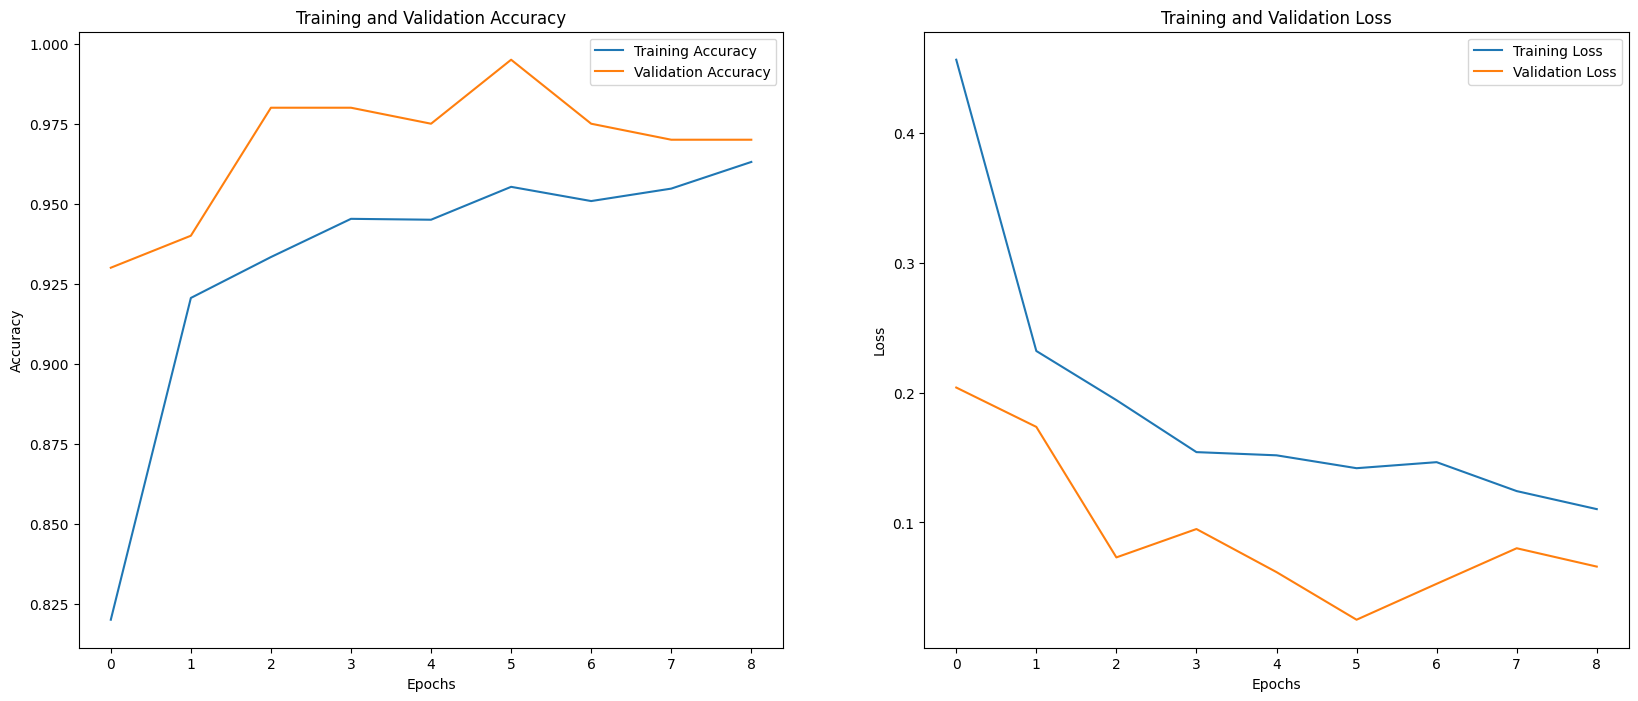

In [16]:
def plot_training_history(history):
    # Grafik Akurasi
    plt.figure(figsize=(20, 8))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Grafik Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    
    plt.show()

plot_training_history(history)

### Model Evalution 

In [17]:
# Buat prediksi pada data uji
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)  # Mengambil kelas dengan probabilitas tertinggi
y_true = test_gen.classes  # Label sebenarnya

# Menghitung metrik evaluasi
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=test_gen.class_indices.keys()))

# Jika ingin mendapatkan masing-masing nilai metrik
f1 = f1_score(y_true, y_pred_classes, average='weighted')
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')

print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 30s 6s/step
Classification Report:
                precision    recall  f1-score   support

   Common Rust       0.93      0.98      0.95        42
Grey Leaf Spot       1.00      0.98      0.99        58
       Healthy       1.00      0.98      0.99        54
   Leaf Blight       0.98      0.98      0.98        46

      accuracy                           0.98       200
     macro avg       0.98      0.98      0.98       200
  weighted avg       0.98      0.98      0.98       200

F1 Score: 0.9801874545231187
Precision: 0.9806818181818181
Recall: 0.98


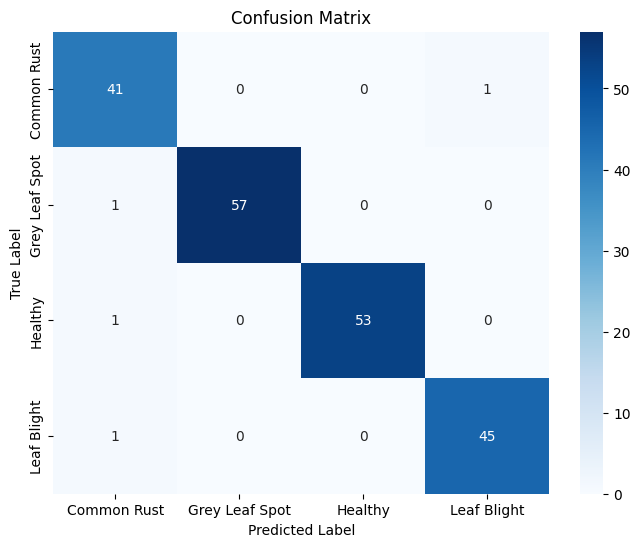

In [18]:
# Menghitung confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix menggunakan seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_gen.class_indices.keys(), yticklabels=test_gen.class_indices.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### Save Model to H5 and Predict

In [20]:
save_dir = r'C:\Users\asus\Bayu\Kuliah\SMT 7\Bangkit\Capstone\capstone_env\Corn\saved_model'

model_name = "corn_model"
save_id = f'{model_name}.h5'
save_loc = os.path.join(save_dir, save_id)

save_model(model, save_loc)

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


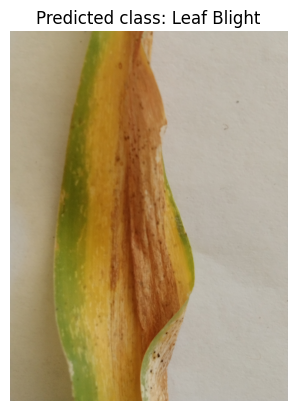

Common Rust: 0.0000
Grey Leaf Spot: 0.0000
Healthy: 0.0000
Leaf Blight: 1.0000


In [21]:
# Path gambar
image_path = r"C:\Users\asus\Bayu\Kuliah\SMT 7\Bangkit\Capstone\capstone_env\Corn\Testing corn\leaf_blight3.jpg"

# Dimensi target gambar
height, width = 256, 256  # Ubah sesuai dengan dimensi input model Anda

# Load dan preprocess gambar
img = image.load_img(image_path, target_size=(height, width))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

# Prediksi menggunakan model
model = load_model(r"C:\Users\asus\Bayu\Kuliah\SMT 7\Bangkit\Capstone\capstone_env\Corn\saved_model\corn_model.h5")
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions[0])
predicted_probability = predictions[0][predicted_class]

# Daftar kelas

classes = ['Common Rust', 'Grey Leaf Spot', 'Healthy', 'Leaf Blight'] 

# Menampilkan gambar dengan prediksi
plt.imshow(image.load_img(image_path))
plt.title(f'Predicted class: {classes[predicted_class]}')
plt.axis('off')  # Menghilangkan axis
plt.show()

for i, class_name in enumerate(classes):
    print(f'{class_name}: {predictions[0][i]:.4f}')

### Save Model to TFLite and Predict

In [22]:
# Muat model Keras
model = tf.keras.models.load_model(r"C:\Users\asus\Bayu\Kuliah\SMT 7\Bangkit\Capstone\capstone_env\Corn\saved_model\corn_model.h5")

# Konversi model ke TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Tambahkan metadata untuk preprocessing (misalnya normalisasi)
metadata = {
    "input_type": "float32",
    "normalize": "true",  # Jika model menggunakan normalisasi
    "image_size": [256, 256]  # Ukuran input model
}
converter.metadata = metadata

# Konversi ke TFLite
tflite_model = converter.convert()

# Simpan model TFLite
with open('model_corn.tflite', 'wb') as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\asus\AppData\Local\Temp\tmpry0itjeu\assets


INFO:tensorflow:Assets written to: C:\Users\asus\AppData\Local\Temp\tmpry0itjeu\assets


Saved artifact at 'C:\Users\asus\AppData\Local\Temp\tmpry0itjeu'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  2449106440976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2449106439824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2449106438864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2449106440016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2449106440400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2449106437520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2449106436560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2449106440208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2449106437136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2449106439248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  24491

Input shape yang diharapkan oleh model: [  1 256 256   3]


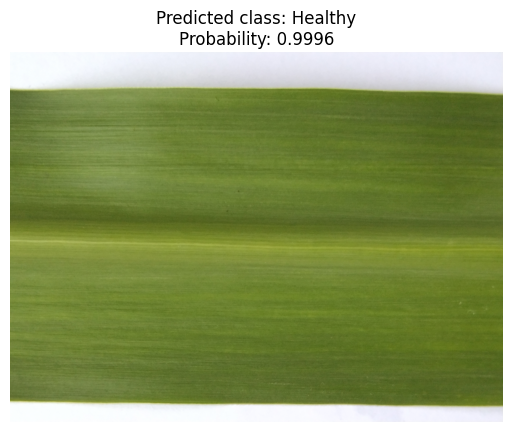

Common Rust: 0.0004
Grey Leaf Spot: 0.0000
Healthy: 0.9996
Leaf Blight: 0.0000


In [23]:
# Path gambar
image_path = r"C:\Users\asus\Bayu\Kuliah\SMT 7\Bangkit\Capstone\capstone_env\Corn\Testing corn\healthy2.jpg"

# Dimensi target gambar
height, width = 256, 256  # Ubah sesuai dengan dimensi input model Anda

# Load dan preprocess gambar
img = image.load_img(image_path, target_size=(height, width))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Tambahkan dimensi batch (shape menjadi [1, height, width, 3])

# Normalisasi gambar (pastikan ini sesuai dengan model Anda)
img_array /= 255.0  # Pastikan normalisasi sesuai dengan yang dilakukan saat pelatihan model

# Muat model TensorFlow Lite
tflite_model_path = r"C:\Users\asus\Bayu\Kuliah\SMT 7\Bangkit\Capstone\capstone_env\Corn\model_corn.tflite"
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

# Mendapatkan informasi tentang tensor input dan output
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Memeriksa bentuk input tensor yang diharapkan
input_shape = input_details[0]['shape']  # Contoh: [1, 256, 256, 3]
print(f"Input shape yang diharapkan oleh model: {input_shape}")

# Memastikan input tensor sesuai dengan model
input_data = np.array(img_array, dtype=np.float32)  # Pastikan tipe data sesuai

# Set tensor input
interpreter.set_tensor(input_details[0]['index'], input_data)

# Jalankan inferensi
interpreter.invoke()

# Ambil hasil prediksi
output_data = interpreter.get_tensor(output_details[0]['index'])
predictions = output_data[0]

# Menentukan kelas dengan probabilitas tertinggi
predicted_class = np.argmax(predictions)
predicted_probability = predictions[predicted_class]  # Probabilitas kelas yang diprediksi

# Daftar kelas
classes = ['Common Rust', 'Grey Leaf Spot', 'Healthy', 'Leaf Blight']

# Menampilkan gambar dengan prediksi dan probabilitas
plt.imshow(image.load_img(image_path))
plt.title(f'Predicted class: {classes[predicted_class]}\nProbability: {predicted_probability:.4f}')
plt.axis('off')  # Menghilangkan axis
plt.show()

# Menampilkan semua probabilitas untuk setiap kelas
for i, class_name in enumerate(classes):
    print(f'{class_name}: {predictions[i]:.4f}')
